# Importing Packages and Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('churn_data.csv')

# Data PreProcessing

In [3]:
# Converts total charges from string to float
df['Total Charges'] = df['Total Charges'].replace(r'^\s*$', np.nan, regex=True)
df['Total Charges'] = df['Total Charges'].astype(float)
# Choosing variables apart from Churn Label, Churn reason (not applicable for modelling)
df1 = df[['Country', 'State', 'City','Zip Code', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security','Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV','Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method','Monthly Charges', 'Total Charges','Churn Value']]

In [4]:
# One hot encodeing all variables
df_encoded = pd.get_dummies(df1, columns=['Gender', 'Senior Citizen', 'Partner', 'Dependents','Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security','Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV','Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method'])

In [5]:
# Dropping dummy variables
df_encoded = df_encoded.drop(['Multiple Lines_No phone service', 'Online Security_No internet service', 'Online Backup_No internet service','Device Protection_No internet service', 'Tech Support_No internet service', 'Streaming TV_No internet service', 'Streaming Movies_No internet service', 'Gender_Female', 'Senior Citizen_No', 'Partner_No', 'Paperless Billing_No', 'Dependents_No', 'Phone Service_No', 'Multiple Lines_No', 'Internet Service_No', 'Online Security_No', 'Online Backup_No', 'Device Protection_No', 'Tech Support_No', 'Streaming TV_No', 'Streaming Movies_No', 'Contract_One year', 'Payment Method_Mailed check'], axis = 1)
# Scaling continuous variable
scaler = StandardScaler()
df_encoded[['Tenure Months', 'Monthly Charges', 'Total Charges']] = scaler.fit_transform(df_encoded[['Tenure Months', 'Monthly Charges', 'Total Charges']])
df_encoded.head()

,Country,State,City,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,...,Device Protection_Yes,Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Contract_Month-to-month,Contract_Two year,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check
0,United States,California,Los Angeles,90003,33.964131,-118.272783,-1.236724,-0.362660,-0.959649,1,...,0,0,0,0,1,0,1,0,0,0
1,United States,California,Los Angeles,90005,34.059281,-118.307420,-1.236724,0.197365,-0.940457,1,...,0,0,0,0,1,0,1,0,0,1
2,United States,California,Los Angeles,90006,34.048013,-118.293953,-0.992402,1.159546,-0.645369,1,...,1,0,1,1,1,0,1,0,0,1
3,United States,California,Los Angeles,90010,34.062125,-118.315709,-0.177995,1.330711,0.336516,1,...,1,1,1,1,1,0,1,0,0,1
4,United States,California,Los Angeles,90015,34.039224,-118.266293,0.677133,1.294151,1.214589,1,...,1,0,1,1,1,0,1,1,0,0


In [6]:
df_la = df_encoded[df_encoded['Zip Code'] == 90012]
df_la.columns

Index(['Country', 'State', 'City', 'Zip Code', 'Latitude', 'Longitude',
       'Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'Gender_Male', 'Senior Citizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'Phone Service_Yes', 'Multiple Lines_Yes', 'Internet Service_DSL',
       'Internet Service_Fiber optic', 'Online Security_Yes',
       'Online Backup_Yes', 'Device Protection_Yes', 'Tech Support_Yes',
       'Streaming TV_Yes', 'Streaming Movies_Yes', 'Contract_Month-to-month',
       'Contract_Two year', 'Paperless Billing_Yes',
       'Payment Method_Bank transfer (automatic)',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check'],
      dtype='object')

In [7]:
# Dealing with Latitude and Longitude variables by finding manhatten distance
from math import radians
import math

# Define the central location
central_lat = radians(34.065875)
central_lon = radians(-118.238728)

# Define a function to calculate the Manhattan distance
def manhattan_distance(lat1, lon1, lat2, lon2):
    """Calculate the Manhattan distance between two points."""
    dx = abs(lon2 - lon1) * 6371 * math.cos((lat1 + lat2) / 2)
    dy = abs(lat2 - lat1) * 6371
    return dx + dy

# Apply the function to each row in the DataFrame
df_encoded['manhattan_distance'] = df_encoded.apply(lambda x: manhattan_distance(radians(x['Latitude']), radians(x['Longitude']), central_lat, central_lon), axis=1)

# View the updated DataFrame
df_encoded.head()

,Country,State,City,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,...,Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Contract_Month-to-month,Contract_Two year,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,manhattan_distance
0,United States,California,Los Angeles,90003,33.964131,-118.272783,-1.236724,-0.362660,-0.959649,1,...,0,0,0,1,0,1,0,0,0,14.452214
1,United States,California,Los Angeles,90005,34.059281,-118.307420,-1.236724,0.197365,-0.940457,1,...,0,0,0,1,0,1,0,0,1,7.060907
2,United States,California,Los Angeles,90006,34.048013,-118.293953,-0.992402,1.159546,-0.645369,1,...,0,1,1,1,0,1,0,0,1,7.073653
3,United States,California,Los Angeles,90010,34.062125,-118.315709,-0.177995,1.330711,0.336516,1,...,1,1,1,1,0,1,0,0,1,7.508106
4,United States,California,Los Angeles,90015,34.039224,-118.266293,0.677133,1.294151,1.214589,1,...,0,1,1,1,0,1,1,0,0,5.502956


In [8]:
df_encoded[['manhattan_distance']] = scaler.fit_transform(df_encoded[['manhattan_distance']])
df_features = df_encoded.drop(['Latitude', 'Longitude', 'Zip Code', 'Country', 'State', 'City'], axis=1)
df_features = df_features.dropna()

In [9]:
data = df_features

X = data.drop(['Churn Value'], axis=1)
y = data['Churn Value']


# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)


In [12]:
def evaluate_model(name, train_preds, test_preds):
    print(f"Evaluation of {name} model:")
    print("Training set:")
    print("F1 Score (Per Class):", f1_score(y_train, np.round(train_preds), average=None))
    print("AUC Score:", roc_auc_score(y_train, train_preds))
    
    cm_train = confusion_matrix(y_train, np.round(train_preds))
    cm_train_percent = cm_train / cm_train.sum(axis=1, keepdims=True) * 100
    sns.heatmap(cm_train_percent, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"Confusion matrix ({name} model) - Training set (Percentages)")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("Test set:")
    print("F1 Score (Per Class):", f1_score(y_test, np.round(test_preds), average=None))
    print("AUC Score:", roc_auc_score(y_test, test_preds))
    
    cm_test = confusion_matrix(y_test, np.round(test_preds))
    cm_test_percent = cm_test / cm_test.sum(axis=1, keepdims=True) * 100
    sns.heatmap(cm_test_percent, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"Confusion matrix ({name} model) - Test set (Percentages)")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Naive Bayes Model

Evaluation of Naive Bayes model:
Training set:
F1 Score (Per Class): [0.73807986 0.771348  ]
AUC Score: 0.7558419657913755


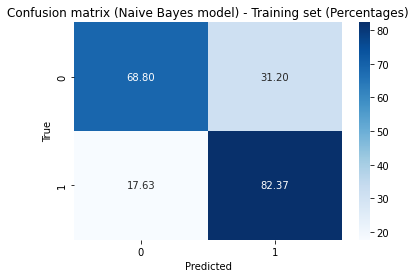

Test set:
F1 Score (Per Class): [0.78579481 0.63461538]
AUC Score: 0.7620891079201482


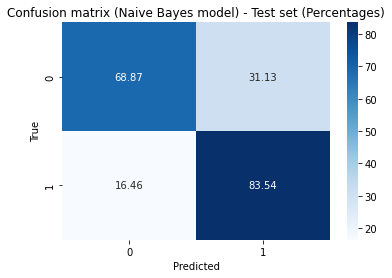

In [14]:
# Fit the Naive Bayes model on the train set
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = nb.predict(X_test)


# Predict the target variable on the train set
y_pred_train = nb.predict(X_train)

evaluate_model("Naive Bayes", y_pred_train, y_pred)

